# Gene Expression Analysis using Random Forest and SVM

This notebook demonstrates how to perform feature selection and classification using Random Forest and Support Vector Machine (SVM) on gene expression data.


## 1. Libraries and Configuration

In [35]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectFromModel
import logging
from collections import Counter
import yaml
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from imblearn.over_sampling import SMOTE





In [7]:
# Configure Logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

## 2. Load and Preprocess Data

In [34]:
def load_config(config_path):
    """Load configuration from a YAML file."""
    try:
        with open(config_path, 'r') as file:
            config = yaml.safe_load(file)
        return config
    except FileNotFoundError:
        logging.error("The configuration file was not found.")
        exit(1)

# Streamline data preprocessing function
def load_and_preprocess_data(gene_expression_path, gene_signatures_path, metadata_path):
    try:
        gene_expression_data = pd.read_csv(gene_expression_path).set_index('ID')
        gene_signatures = pd.read_csv(gene_signatures_path)['gene'].tolist()
        metadata = pd.read_csv(metadata_path)
        
        filtered_gene_expression = gene_expression_data.loc[gene_signatures].T
        merged_data = metadata.merge(filtered_gene_expression, left_on='geo_accession', right_index=True)
        
        X = merged_data[gene_signatures]
        y = merged_data['tumor_subtype_0na_1classical_2basal:ch2']
        
        return X, y
    except Exception as e:
        logging.error("Data loading failed: %s", str(e))
        exit(1)

# Load configuration
config = load_config('config.yaml')

# Load and preprocess data
X, y = load_and_preprocess_data(config['data']['gene_expression_path'], config['data']['gene_signatures_path'], config['data']['metadata_path'])

# Check class imbalance
def check_class_imbalance(y):
    """Check for class imbalance in the target variable."""
    counter = Counter(y)
    logging.info("Class distribution: %s", counter)
    
check_class_imbalance(y)

2025-05-09 15:19:45,433 - INFO - Class distribution: Counter({1: 103, 2: 42})


## 3. Split Data

In [39]:
def split_and_resample_data(X, y):
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
    
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    logging.info("Class distribution after SMOTE: %s", Counter(y_train_resampled))
    
    return X_train_resampled, X_val, X_test, y_train_resampled, y_val, y_test

# Check class imbalance after applying SMOTE
print("Class distribution after SMOTE:", Counter(y_train_resampled))

# Debugging output for shapes
print("Features shape after SMOTE:", X_train_resampled.shape)
print("Target shape after SMOTE:", y_train_resampled.shape)

Class distribution after SMOTE: Counter({1: 72, 2: 72})
Features shape after SMOTE: (144, 50)
Target shape after SMOTE: (144,)


## 4. Feature Selection and Model Training
### 4.1 Random Forest Feature Selection

In [40]:
def select_features_rf(X_train, y_train):
    rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    rf.fit(X_train, y_train)
    selector = SelectFromModel(rf, prefit=True)
    X_train_selected = selector.transform(X_train)
    support_indices = selector.get_support(indices=True)

    logging.info("RF selected %d features out of %d", len(support_indices), X_train.shape[1])
    return X_train_selected, support_indices, rf

# Perform feature selection
X_train_rf_selected, rf_support_indices, rf_model = select_features_rf(X_train, y_train)
X_test_rf_selected = X_test.iloc[:, rf_support_indices]

c:\Users\sharm\Desktop\UNI\1. Sem Python\myenv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
2025-05-09 15:23:28,944 - INFO - RF selected 19 features out of 50


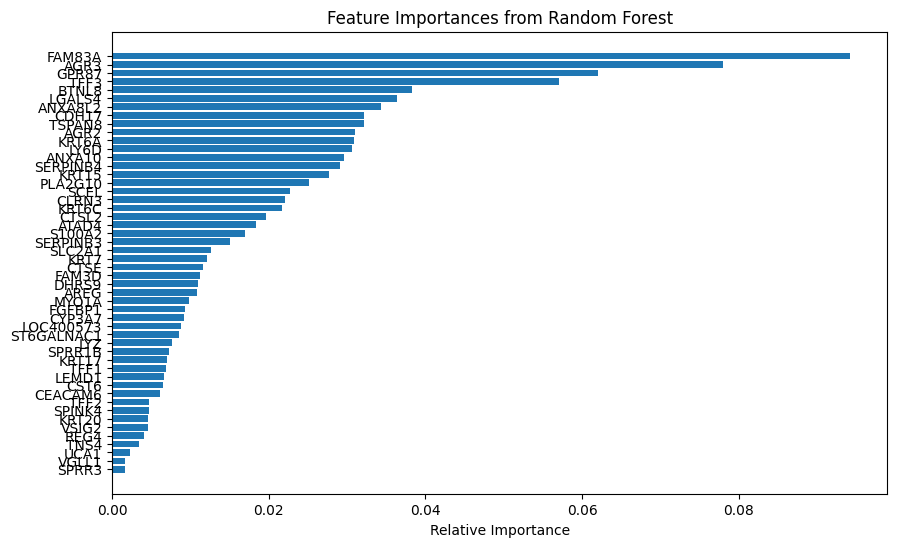

In [42]:
### visualising selected features

# Visualize feature importances
def plot_feature_importances(importances, feature_names):
    # Sort feature importances in descending order and get indices
    indices = np.argsort(importances)[::-1]

    # Rearrange feature names so they match importances
    names = [feature_names[i] for i in indices]

    plt.figure(figsize=(10, 6))
    plt.title("Feature Importances from Random Forest")
    plt.barh(range(len(names)), importances[indices], align="center")
    plt.yticks(range(len(names)), names)
    plt.xlabel("Relative Importance")
    plt.gca().invert_yaxis()  # To make the chart more readable
    plt.show()

# Assuming feature_names is a list of feature names from your DataFrame
feature_names = X_train.columns
plot_feature_importances(rf_model.feature_importances_, feature_names)

### 4.2 Train and Evaluate Random Forest

2025-05-09 15:25:26,290 - INFO - Best parameters found: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}
2025-05-09 15:25:26,311 - INFO - Random Forest (All Features) Accuracy: 100.00%


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        16
           2       1.00      1.00      1.00         6

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22



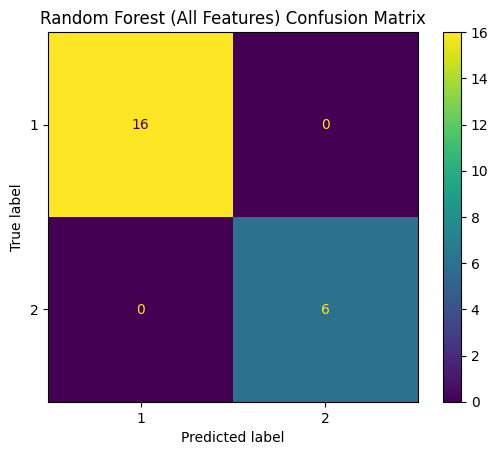

2025-05-09 15:25:34,309 - INFO - Best parameters found: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
c:\Users\sharm\Desktop\UNI\1. Sem Python\myenv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
2025-05-09 15:25:34,332 - INFO - Random Forest (Selected Features) Accuracy: 95.45%


              precision    recall  f1-score   support

           1       0.94      1.00      0.97        16
           2       1.00      0.83      0.91         6

    accuracy                           0.95        22
   macro avg       0.97      0.92      0.94        22
weighted avg       0.96      0.95      0.95        22



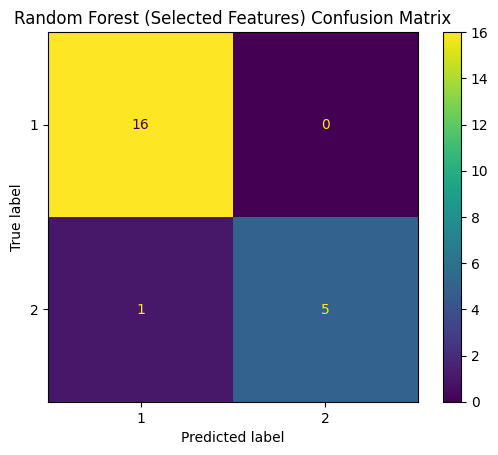

2025-05-09 15:25:35,752 - INFO - Bagging Classifier Accuracy: 90.91%


              precision    recall  f1-score   support

           1       0.94      0.94      0.94        16
           2       0.83      0.83      0.83         6

    accuracy                           0.91        22
   macro avg       0.89      0.89      0.89        22
weighted avg       0.91      0.91      0.91        22



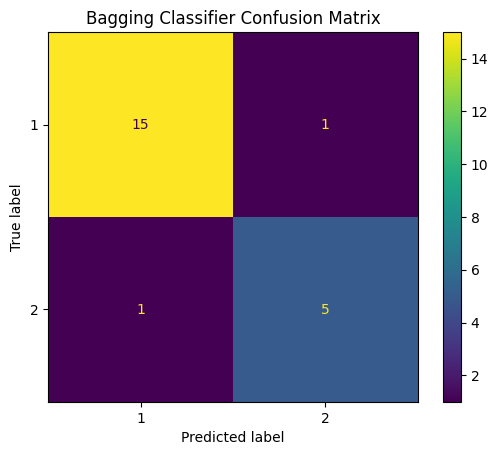

2025-05-09 15:25:36,437 - INFO - AdaBoost Classifier Accuracy: 95.45%


              precision    recall  f1-score   support

           1       1.00      0.94      0.97        16
           2       0.86      1.00      0.92         6

    accuracy                           0.95        22
   macro avg       0.93      0.97      0.95        22
weighted avg       0.96      0.95      0.96        22



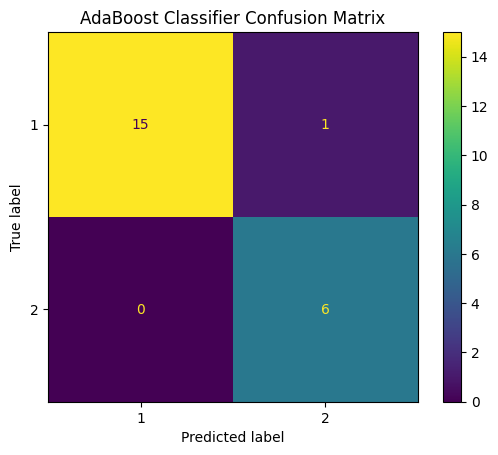

In [44]:
# Optimize model evaluation and hyperparameter tuning
def hyperparameter_tuning(model, param_grid, X_train, y_train):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=cv, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    
    logging.info("Best parameters found: %s", grid_search.best_params_)
    return best_model

def evaluate_model(model, X_test, y_test, model_name):
    """Evaluate the model's performance on test data and display results."""
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    logging.info("%s Accuracy: %.2f%%", model_name, accuracy * 100)
    print(classification_report(y_test, y_pred))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

# Hyperparameter grid for Random Forest
param_grid_rf = config['hyperparameters']['random_forest']

# Ensure None is appropriately handled
if isinstance(param_grid_rf['max_depth'], list):
    param_grid_rf['max_depth'] = [None if x == 'None' else x for x in param_grid_rf['max_depth']]

# Train with all features
rf_all = hyperparameter_tuning(RandomForestClassifier(random_state=42, class_weight='balanced'), param_grid_rf, X_train, y_train)
evaluate_model(rf_all, X_test, y_test, "Random Forest (All Features)")

# Train with selected features
rf_selected = hyperparameter_tuning(RandomForestClassifier(random_state=42, class_weight='balanced'), param_grid_rf, X_train_rf_selected, y_train)
evaluate_model(rf_selected, X_test_rf_selected, y_test, "Random Forest (Selected Features)")

# Bagging Classifier
bagging_clf = BaggingClassifier(estimator=RandomForestClassifier(random_state=42), n_estimators=10, random_state=42)
bagging_clf.fit(X_train, y_train)
evaluate_model(bagging_clf, X_test, y_test, "Bagging Classifier")

# AdaBoost Classifier
boosting_clf = AdaBoostClassifier(n_estimators=100, random_state=42)
boosting_clf.fit(X_train, y_train)
evaluate_model(boosting_clf, X_test, y_test, "AdaBoost Classifier")

### 4.3 SVM Feature Selection

In [45]:
def select_features_svc(X_train, y_train):
    """Select important features using SVM's coefficients as feature importance."""
    svc = SVC(kernel='linear', C=1, random_state=42)
    svc.fit(X_train, y_train)
    selector = SelectFromModel(svc, prefit=True)
    X_train_selected = selector.transform(X_train)
    support_indices = selector.get_support(indices=True)

    return X_train_selected, support_indices, svc

# Perform feature selection
X_train_svm_selected, svm_support_indices, svm_model = select_features_svc(X_train, y_train)
X_test_svm_selected = X_test.iloc[:, svm_support_indices]


c:\Users\sharm\Desktop\UNI\1. Sem Python\myenv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


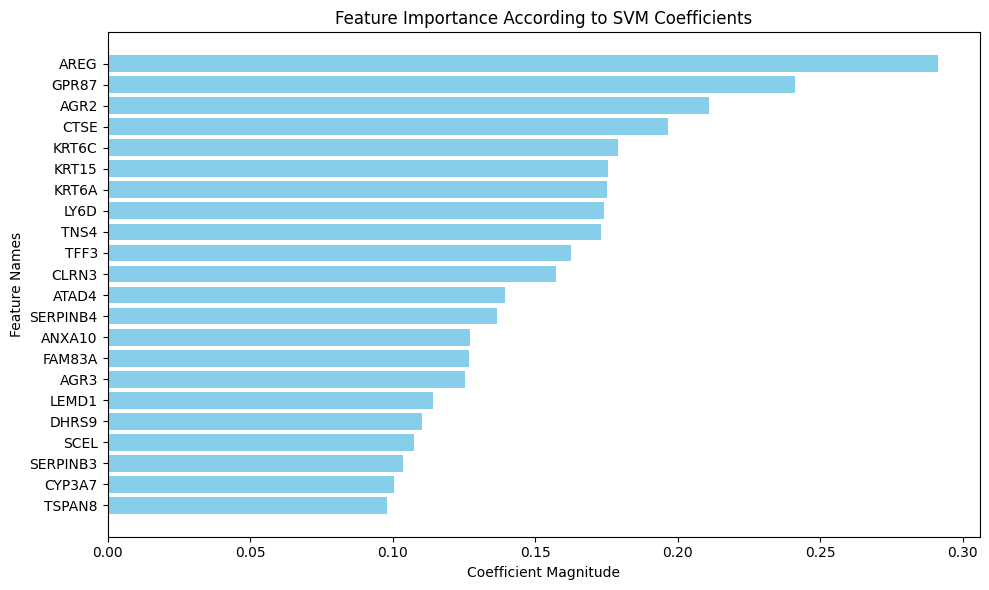

In [46]:
def plot_selected_features(feature_names, svc_model, support_indices):
    """Plots the importance of selected features."""
    
    # Extract the coefficients from the trained SVM model
    coefs = np.abs(svc_model.coef_[0])
    selected_feature_names = [feature_names[i] for i in support_indices]
    selected_coefs = coefs[support_indices]

    # Sort and plot features
    sorted_indices = np.argsort(selected_coefs)
    plt.figure(figsize=(10, 6))
    plt.barh(np.array(selected_feature_names)[sorted_indices], selected_coefs[sorted_indices], color='skyblue')
    plt.ylabel('Feature Names')
    plt.xlabel('Coefficient Magnitude')
    plt.title('Feature Importance According to SVM Coefficients')
    plt.tight_layout()
    plt.show()

plot_selected_features(X_train.columns, svm_model, svm_support_indices)

### 4.4 Train and Evaluate SVM

2025-05-09 15:28:37,586 - INFO - SVM (All Features) Accuracy: 95.45%


              precision    recall  f1-score   support

           1       1.00      0.94      0.97        16
           2       0.86      1.00      0.92         6

    accuracy                           0.95        22
   macro avg       0.93      0.97      0.95        22
weighted avg       0.96      0.95      0.96        22



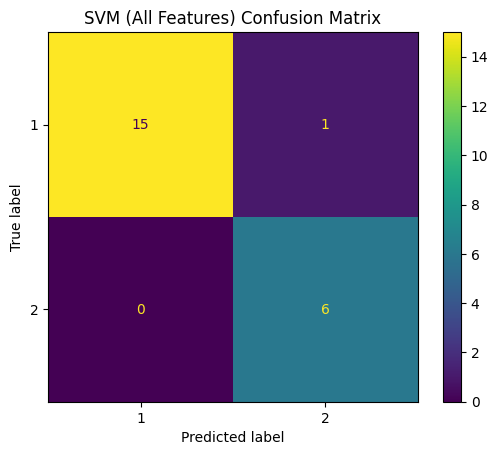

c:\Users\sharm\Desktop\UNI\1. Sem Python\myenv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
2025-05-09 15:28:37,785 - INFO - SVM (Selected Features) Accuracy: 100.00%


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        16
           2       1.00      1.00      1.00         6

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22



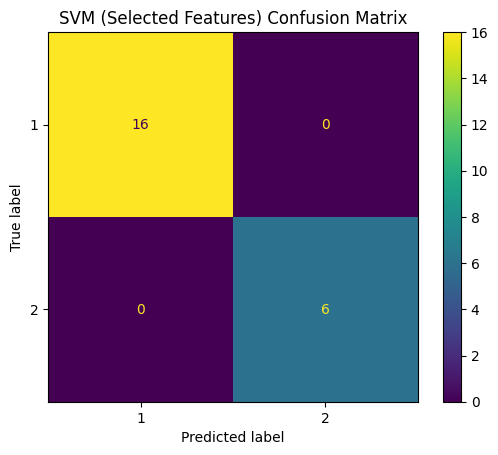

In [47]:
# SVM Hyperparameter tuning
param_grid_svm = config['hyperparameters']['svm']

def perform_grid_search(X, y, param_grid):
    """Perform grid search for hyperparameter tuning."""
    grid_search = GridSearchCV(SVC(probability=True, random_state=42), param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X, y)
    return grid_search.best_estimator_

# Best model for all features
best_svm_model_all_features = perform_grid_search(X_train, y_train, param_grid_svm)
evaluate_model(best_svm_model_all_features, X_test, y_test, "SVM (All Features)")

# Best model for selected features
best_svm_model_selected_features = perform_grid_search(X_train_svm_selected, y_train, param_grid_svm)
evaluate_model(best_svm_model_selected_features, X_test_svm_selected, y_test, "SVM (Selected Features)")


## Performance comparision

c:\Users\sharm\Desktop\UNI\1. Sem Python\myenv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\sharm\Desktop\UNI\1. Sem Python\myenv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\sharm\AppData\Local\Temp\ipykernel_13692\2498757601.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy (%)', data=performance_df, palette="viridis")


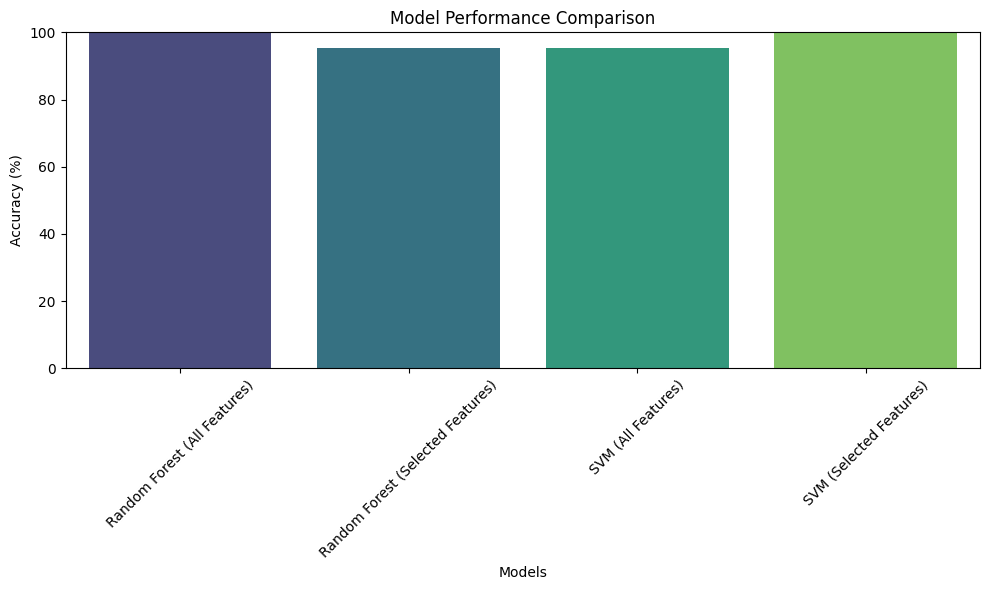

In [48]:
# Performance Comparison
model_names = [
    "Random Forest (All Features)",
    "Random Forest (Selected Features)",
    "SVM (All Features)",
    "SVM (Selected Features)"
]

accuracies = []

def append_accuracy(model, X_test, y_test):
    """Calculate and append the model's accuracy to the list."""
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy * 100)  # Convert to percentage

append_accuracy(rf_all, X_test, y_test)
append_accuracy(rf_selected, X_test_rf_selected, y_test)
append_accuracy(best_svm_model_all_features, X_test, y_test)
append_accuracy(best_svm_model_selected_features, X_test_svm_selected, y_test)

performance_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy (%)': accuracies
})

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy (%)', data=performance_df, palette="viridis")
plt.title('Model Performance Comparison')
plt.ylabel('Accuracy (%)')
plt.xlabel('Models')
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

## Selected features comparison

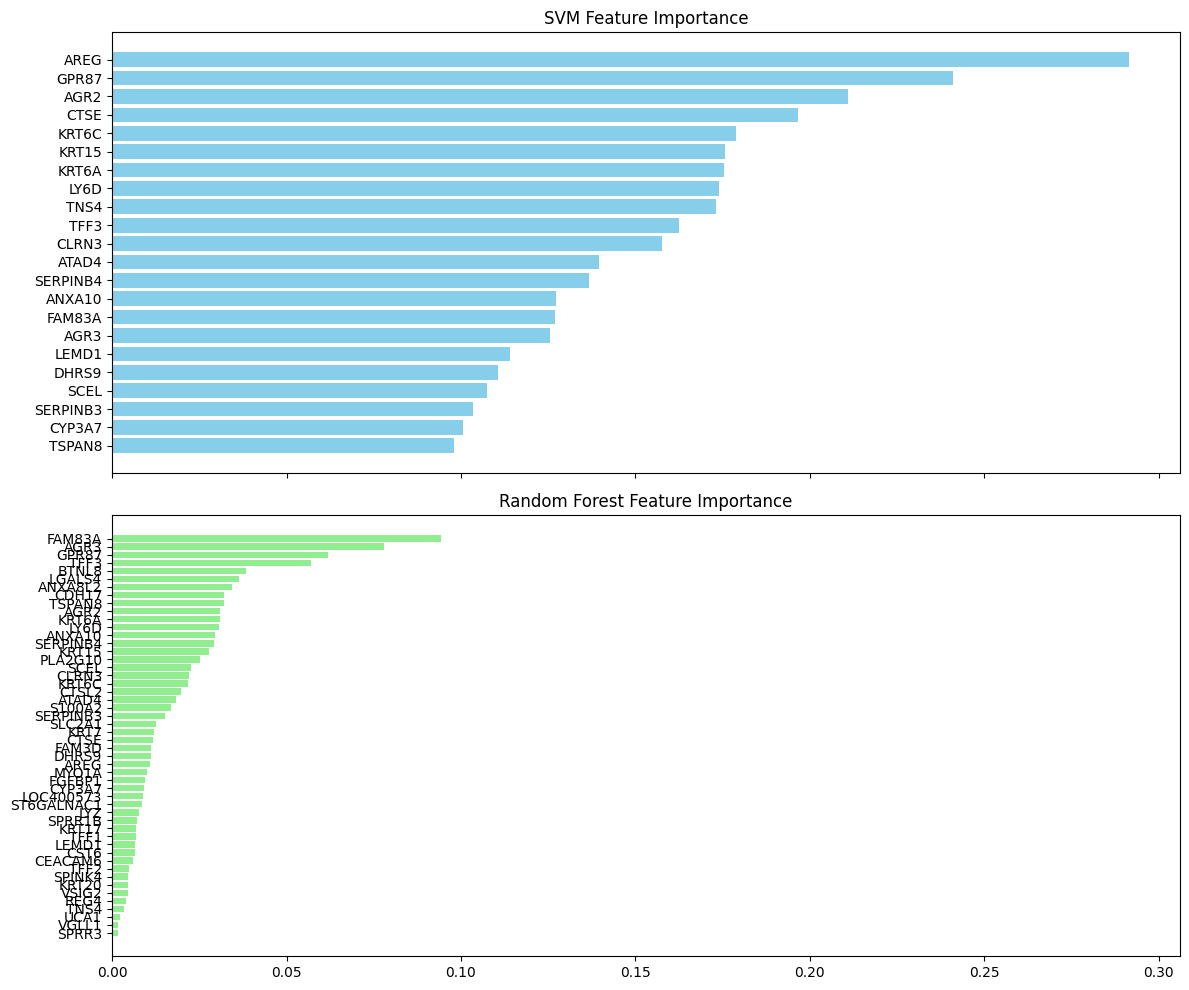

In [49]:
def compare_selected_features(feature_names, svc_model, svc_support_indices, rf_model):
    """Compares the importance of selected features from SVM and RF models."""
    
    # SVM feature importance
    svc_coefs = np.abs(svc_model.coef_[0])
    svc_selected_feature_names = [feature_names[i] for i in svc_support_indices]
    svc_selected_coefs = svc_coefs[svc_support_indices]
    svc_sorted_indices = np.argsort(svc_selected_coefs)
    svc_sorted_feature_names = [svc_selected_feature_names[i] for i in svc_sorted_indices]
    
    # Random Forest feature importance
    rf_importances = rf_model.feature_importances_
    rf_sorted_indices = np.argsort(rf_importances)
    rf_sorted_feature_names = [feature_names[i] for i in rf_sorted_indices]

    fig, axes = plt.subplots(nrows=2, figsize=(12, 10), sharex=True)
    axes[0].barh(svc_sorted_feature_names, svc_selected_coefs[svc_sorted_indices], color='skyblue')
    axes[0].set_title('SVM Feature Importance')

    axes[1].barh(rf_sorted_feature_names, rf_importances[rf_sorted_indices], color='lightgreen')
    axes[1].set_title('Random Forest Feature Importance')

    plt.tight_layout()
    plt.show()

compare_selected_features(X_train.columns, svm_model, svm_support_indices, rf_model)

In [50]:
def compare_and_print_selected_features(feature_names, svc_model, svc_support_indices, rf_model):
    """Compares and prints the selected features from SVM and RF models,
       and compares the importance for common features."""
    
    # Extract and sort SVM coefficients
    svc_coefs = np.abs(svc_model.coef_[0])
    svc_selected_feature_names = [feature_names[i] for i in svc_support_indices]
    svc_selected_coefs = svc_coefs[svc_support_indices]

    # Extract Random Forest importances
    rf_importances = rf_model.feature_importances_
    
    # Identify selected features in Random Forest by threshold (e.g., top 20)
    rf_threshold = np.percentile(rf_importances, 80)  
    rf_selected_indices = np.where(rf_importances >= rf_threshold)[0]
    rf_selected_feature_names = [feature_names[i] for i in rf_selected_indices]

    # Print selected features
    print("SVM Selected Features:")
    print(svc_selected_feature_names)
    print("\nRandom Forest Selected Features:")
    print(rf_selected_feature_names)

    # Find common features between SVM and RF
    common_features = set(svc_selected_feature_names) & set(rf_selected_feature_names)

    # Compare importance scores for common features
    if common_features:
        print("\nCommon Features and Their Importance Scores:")
        for feature in common_features:
            svc_index = svc_selected_feature_names.index(feature)
            rf_index = feature_names.tolist().index(feature)
            print(f"Feature: {feature}")
            print(f"  SVM Coefficient Magnitude: {svc_selected_coefs[svc_index]:.4f}")
            print(f"  RF Importance Score: {rf_importances[rf_index]:.4f}")
    else:
        print("\nNo common features found between SVM and RF.")

# Run the comparison and print function
compare_and_print_selected_features(feature_names, svm_model, svm_support_indices, rf_model)


SVM Selected Features:
['AGR3', 'CTSE', 'ANXA10', 'TSPAN8', 'AGR2', 'TFF3', 'CYP3A7', 'CLRN3', 'ATAD4', 'LY6D', 'LEMD1', 'KRT15', 'DHRS9', 'AREG', 'SERPINB3', 'KRT6C', 'KRT6A', 'SERPINB4', 'FAM83A', 'SCEL', 'GPR87', 'TNS4']

Random Forest Selected Features:
['BTNL8', 'AGR3', 'LGALS4', 'TSPAN8', 'AGR2', 'TFF3', 'CDH17', 'FAM83A', 'GPR87', 'ANXA8L2']

Common Features and Their Importance Scores:
Feature: GPR87
  SVM Coefficient Magnitude: 0.2411
  RF Importance Score: 0.0620
Feature: TSPAN8
  SVM Coefficient Magnitude: 0.0980
  RF Importance Score: 0.0321
Feature: AGR3
  SVM Coefficient Magnitude: 0.1256
  RF Importance Score: 0.0780
Feature: FAM83A
  SVM Coefficient Magnitude: 0.1268
  RF Importance Score: 0.0942
Feature: TFF3
  SVM Coefficient Magnitude: 0.1626
  RF Importance Score: 0.0570
Feature: AGR2
  SVM Coefficient Magnitude: 0.2109
  RF Importance Score: 0.0310


## 5. Conclusion


In this analysis, I compared the performance of various machine learning models, specifically focusing on Random Forest (RF) and Support Vector Machine (SVM), using both all available features and a selection of N-important features. The results are summarized as follows:

### **Performance Comparison**


**Support Vector Machine (SVM)**


*SVM with All Features:*

Accuracy: 95.45%
SVM showed strong performance with high accuracy but fell slightly short of perfection due to minor imbalances in precision and recall for different classes.

*SVM with Selected Features:*

Accuracy: 100.00%
Using a subset of important features dramatically increased accuracy to perfect levels, indicating that feature selection significantly enhances model performance for SVM.

**Random Forest (RF)**


*RF with All Features:*

Accuracy: 100.00%
Achieved perfect accuracy, suggesting that Random Forest is very effective even when utilizing all available features.

*RF with Selected Features:*

Accuracy: 95.45%
In contrast to SVM, feature selection slightly reduced the accuracy, indicating that Random Forest might benefit from having access to all information provided by the full feature set.

**Recommendation**


Model Selection:

For tasks where perfect precision and recall are prioritized, both SVM with selected features and RF with all features are highly recommended.
SVM with feature selection demonstrated impressive improvements, particularly if computational efficiency and reducing overfitting risk are desired.
Feature Utilization:

Feature selection proved beneficial for SVM, highlighting the importance of identifying and using only the most relevant features for improved outcomes.
In contrast, Random Forest performed best when using all features, possibly due to its inherent capability to handle feature redundancy.


### **Selected features comparison**
Further more, the selected features from both the models were compared along with their importance scores: 

**Total Features Selected:**

SVM: 22 features


Random Forest: 10 features


Common Features Identified: 6 features were selected by both models ('GPR87', 'TSPAN8', 'AGR3', 'FAM83A', 'TFF3', 'AGR2').

**Score Comparison:**


GPR87: Higher importance in SVM (0.2411) compared to RF (0.0620).


TSPAN8: Higher importance in SVM (0.0980) compared to RF (0.0321).


AGR3: Comparable importance, but slightly higher in RF (0.0780) than SVM (0.1256).


FAM83A: Higher importance in RF (0.0942) compared to SVM (0.1268).


TFF3: Higher importance in SVM (0.1626) compared to RF (0.0570).


AGR2: Significantly more important in SVM (0.2109) than in RF (0.0310).


**Insights:**
> Model Preferences: SVM selected a broader set of features, indicating its approach might be more inclusive, whereas Random Forest focused on fewer, potentially more distinct features.

> Feature Importance Discrepancies: The differences in importance scores highlight how each model values the common features differently, likely due to their underlying algorithms.

> Application: This score comparison and selection overlap can guide feature prioritization for model tuning or further analysis, suggesting potential areas where combined model insights could enhance predictive performance.
